![](https://upload.wikimedia.org/wikipedia/en/c/ca/Simpsons_cast.png)

# Abstract
В данном ноутбуке рассматривается решение задачи классификации изображений в рамках учебного Kaggle-соревнования [Journey to Springfield](#https://www.kaggle.com/c/journey-springfield) от [Deep Learning School](#https://www.dlschool.org/). Для решения используется техника Transfer Learning/Fine tuning над нейронными сетями [`Efficientnet_B4`](#https://arxiv.org/pdf/1905.11946.pdf) и `ResNet 18`, предобученными на ImageNet. В этом блокноте приведён основной training loop, выполняется аугментация изображений, в качестве оптимизатора используется [AdamW](#https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html). Для работы с learning rate используется scheduler [`StepLR`](#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html). Для борьбы с дисбалансом классов используется oversampling.

Метрикой в этом соревновании является `Mean F1-Score`.

## Data Description
Обучающая и тестовая выборки состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа, изображенного на ней. Тест был поделен на приватную и публичную части в соотношении 95/5

В тренировочном датасете примерно по 1000 картинок на каждый класс, но они отличаются размером.

#### Описание файлов
- train.csv - the training set
- testset.csv - the test set
- sampleSubmission.csv - пример submit'а

#### Поля в данных
- image_id - id картинки
- Expected - имя персонажа


## Содержание

1. [Подготовка данных и среды](#preparing)

    - [Сlass SimpsonsDataset](#class_simpsonsDataset)
    
    - [Oversampling](#oversampling)

2. [ResNet 18](#resnet): 
    - [Обучение](#resnet_train)
    
    - [Предсказания](#resnet_predict)
    
    - [Submit на Kaggle](#resnet_sub)

3. [EfficientNet B4](#efficientnet)
    
    - [Обучение](#effic_train)
    
    - [Предсказания](#resnet_predict)
    
    - [Submit на Kaggle](#effic_sub)

4. [Заключение](#conclusion)

<a id='preparing'></a>
## Подготовка данных и среды

In [1]:
import warnings
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches
import os
import copy

import numpy as np
import pandas as pd
import torch

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pickle
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from matplotlib import colors, pyplot as plt
%matplotlib inline


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# Задать значение зерна генератора случайных чисел
# для воспроизводимости результатов
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

<a id='class_simpsonsDataset'></a>
Ниже используется враппер над датасетом для удобной работы. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок,
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch, нормализации входа
        # и аугментации входных изображений на обучении
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=45),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.07, saturation=.1, brightness=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()  # подписи к данным  из  выборок train или val
            return x, y

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [9]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на персонажей датасета

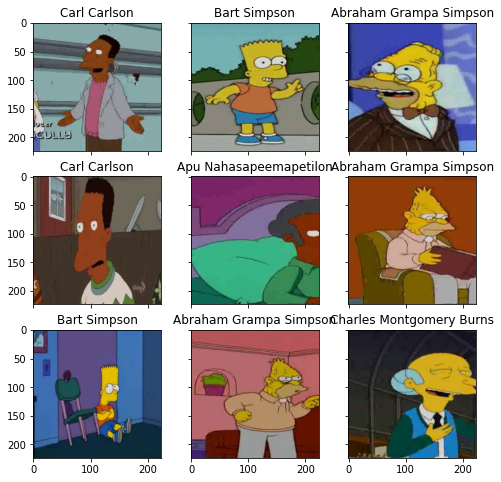

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

In [12]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons


# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

<a id='oversampling'></a>

In [13]:
# Дополним картинки классов у которых менее MIN_SIZE картинок, до MIN_SIZE картинок в классе
MIN_SIZE = 300
for person in dct_path_train:
    if len(dct_path_train[person]) < MIN_SIZE:
        dct_path_train[person] = dct_path_train[person] * \
            (MIN_SIZE // len(dct_path_train[person]))
        dct_path_train[person].extend(
            dct_path_train[person][:MIN_SIZE - len(dct_path_train[person])])
# Проверим что получилось
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	300
apu_nahasapeemapetilon	467
barney_gumble	300
bart_simpson	1006
carl_carlson	300
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	300
comic_book_guy	352
disco_stu	300
edna_krabappel	343
fat_tony	300
gil	300
groundskeeper_willie	300
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	300
lionel_hutz	300
lisa_simpson	1015
maggie_simpson	300
marge_simpson	968
martin_prince	300
mayor_quimby	300
milhouse_van_houten	809
miss_hoover	300
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	300
otto_mann	300
patty_bouvier	300
principal_skinner	895
professor_john_frink	300
rainier_wolfcastle	300
ralph_wiggum	300
selma_bouvier	300
sideshow_bob	658
sideshow_mel	300
snake_jailbird	300
troy_mcclure	300
waylon_smithers	300


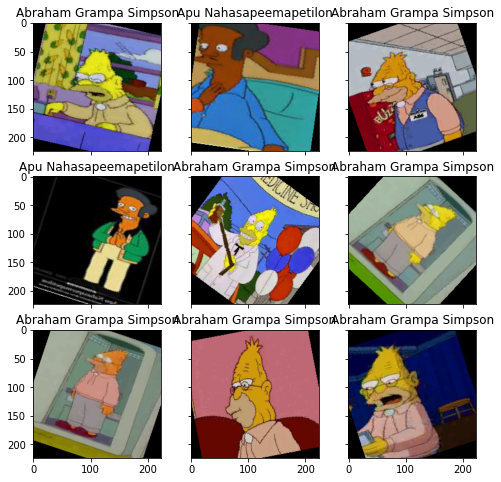

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

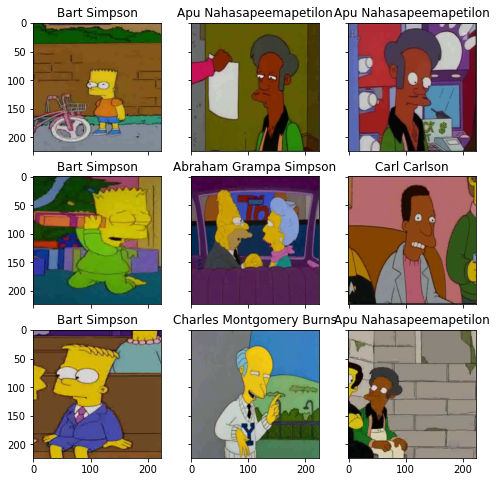

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(
                model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))

--------------
<a id='resnet'></a>
# ResNet 18

In [24]:
model_resnet = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(6

<a id='resnet_train'></a>
## Обучение

Сначала обучим FC-слой, при замороженном feature extractor. Затем дообучим всю сеть

In [25]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(512, 42))

In [26]:
model_resnet = model_resnet.cuda()

In [27]:
history = train(new_train_dataset, val_dataset,
                model=model_resnet, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.551055048688158


epoch:  10%|█         | 1/10 [04:13<37:58, 253.17s/it]


Epoch 001 train_loss: 2.5511     val_loss 2.1310 train_acc 0.3254 val_acc 0.4593
loss 1.858297299521513


epoch:  20%|██        | 2/10 [07:51<32:21, 242.73s/it]


Epoch 002 train_loss: 1.8583     val_loss 1.7988 train_acc 0.5325 val_acc 0.5483
loss 1.615259952410145


epoch:  30%|███       | 3/10 [11:32<27:32, 236.10s/it]


Epoch 003 train_loss: 1.6153     val_loss 1.6466 train_acc 0.5765 val_acc 0.5718
loss 1.4939542863123818


epoch:  40%|████      | 4/10 [15:11<23:07, 231.20s/it]


Epoch 004 train_loss: 1.4940     val_loss 1.5710 train_acc 0.6070 val_acc 0.5919
loss 1.4398738637944093


epoch:  50%|█████     | 5/10 [18:52<18:59, 227.88s/it]


Epoch 005 train_loss: 1.4399     val_loss 1.5337 train_acc 0.6180 val_acc 0.5992
loss 1.394258091417759


epoch:  60%|██████    | 6/10 [22:30<14:59, 224.89s/it]


Epoch 006 train_loss: 1.3943     val_loss 1.5036 train_acc 0.6264 val_acc 0.6001
loss 1.35792867348553


epoch:  70%|███████   | 7/10 [26:08<11:08, 222.82s/it]


Epoch 007 train_loss: 1.3579     val_loss 1.4787 train_acc 0.6332 val_acc 0.6120
loss 1.3409772709833705


epoch:  80%|████████  | 8/10 [29:45<07:22, 221.11s/it]


Epoch 008 train_loss: 1.3410     val_loss 1.4646 train_acc 0.6388 val_acc 0.6131
loss 1.329474502633119


epoch:  90%|█████████ | 9/10 [33:21<03:39, 219.70s/it]


Epoch 009 train_loss: 1.3295     val_loss 1.4501 train_acc 0.6413 val_acc 0.6171
loss 1.3190181061692103


epoch: 100%|██████████| 10/10 [36:59<00:00, 221.90s/it]


Epoch 010 train_loss: 1.3190     val_loss 1.4420 train_acc 0.6455 val_acc 0.6188


In [28]:
# сохранить веса нашей нейросети model_resnet
model_pre_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")

In [29]:
# Включаем все слои
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [30]:
history = train(new_train_dataset, val_dataset,
                model=model_resnet, epochs=25, batch_size=128)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 3.810083293701604


epoch:   4%|▍         | 1/25 [03:39<1:27:47, 219.48s/it]


Epoch 001 train_loss: 3.8101     val_loss 3.1143 train_acc 0.0938 val_acc 0.1074
loss 3.1121277222867874


epoch:   8%|▊         | 2/25 [07:21<1:24:26, 220.27s/it]


Epoch 002 train_loss: 3.1121     val_loss 3.0992 train_acc 0.1020 val_acc 0.1074
loss 3.0520191704285304


epoch:  12%|█▏        | 3/25 [11:01<1:20:45, 220.26s/it]


Epoch 003 train_loss: 3.0520     val_loss 2.9469 train_acc 0.1240 val_acc 0.1492
loss 2.8293827930257147


epoch:  16%|█▌        | 4/25 [14:44<1:17:18, 220.87s/it]


Epoch 004 train_loss: 2.8294     val_loss 2.7512 train_acc 0.1834 val_acc 0.2088
loss 2.6265150214449657


epoch:  20%|██        | 5/25 [18:25<1:13:38, 220.92s/it]


Epoch 005 train_loss: 2.6265     val_loss 2.4381 train_acc 0.2511 val_acc 0.2990
loss 2.3288438455180867


epoch:  24%|██▍       | 6/25 [22:05<1:09:53, 220.71s/it]


Epoch 006 train_loss: 2.3288     val_loss 2.1355 train_acc 0.3328 val_acc 0.3974
loss 1.9112933914991854


epoch:  28%|██▊       | 7/25 [25:50<1:06:34, 221.91s/it]


Epoch 007 train_loss: 1.9113     val_loss 1.5825 train_acc 0.4562 val_acc 0.5579
loss 1.6046836935816509


epoch:  32%|███▏      | 8/25 [29:31<1:02:49, 221.76s/it]


Epoch 008 train_loss: 1.6047     val_loss 1.4343 train_acc 0.5482 val_acc 0.6125
loss 1.3576631032585564


epoch:  36%|███▌      | 9/25 [33:14<59:14, 222.13s/it]  


Epoch 009 train_loss: 1.3577     val_loss 1.1377 train_acc 0.6168 val_acc 0.6928
loss 1.1039343676162015


epoch:  40%|████      | 10/25 [36:54<55:22, 221.50s/it]


Epoch 010 train_loss: 1.1039     val_loss 1.0288 train_acc 0.6936 val_acc 0.7251
loss 0.9918707564761848


epoch:  44%|████▍     | 11/25 [40:36<51:41, 221.56s/it]


Epoch 011 train_loss: 0.9919     val_loss 0.9312 train_acc 0.7259 val_acc 0.7405
loss 0.8985824302482889


epoch:  48%|████▊     | 12/25 [44:17<47:57, 221.36s/it]


Epoch 012 train_loss: 0.8986     val_loss 0.8562 train_acc 0.7514 val_acc 0.7639
loss 0.7870316866080204


epoch:  52%|█████▏    | 13/25 [48:02<44:29, 222.47s/it]


Epoch 013 train_loss: 0.7870     val_loss 0.7733 train_acc 0.7806 val_acc 0.7914
loss 0.73315140884786


epoch:  56%|█████▌    | 14/25 [51:53<41:16, 225.16s/it]


Epoch 014 train_loss: 0.7332     val_loss 0.7141 train_acc 0.7988 val_acc 0.8095
loss 0.7009984112709716


epoch:  60%|██████    | 15/25 [55:41<37:38, 225.83s/it]


Epoch 015 train_loss: 0.7010     val_loss 0.7034 train_acc 0.8075 val_acc 0.8172
loss 0.6398100785455831


epoch:  64%|██████▍   | 16/25 [59:20<33:36, 224.04s/it]


Epoch 016 train_loss: 0.6398     val_loss 0.6809 train_acc 0.8203 val_acc 0.8269
loss 0.6212694627606211


epoch:  68%|██████▊   | 17/25 [1:03:07<29:59, 224.91s/it]


Epoch 017 train_loss: 0.6213     val_loss 0.6618 train_acc 0.8274 val_acc 0.8342
loss 0.6034445119508155


epoch:  72%|███████▏  | 18/25 [1:06:49<26:07, 223.92s/it]


Epoch 018 train_loss: 0.6034     val_loss 0.6422 train_acc 0.8302 val_acc 0.8403
loss 0.5689482844355565


epoch:  76%|███████▌  | 19/25 [1:10:27<22:13, 222.19s/it]


Epoch 019 train_loss: 0.5689     val_loss 0.6388 train_acc 0.8419 val_acc 0.8384
loss 0.5606448814694821


epoch:  80%|████████  | 20/25 [1:14:10<18:32, 222.44s/it]


Epoch 020 train_loss: 0.5606     val_loss 0.6302 train_acc 0.8439 val_acc 0.8420
loss 0.5470667421462462


epoch:  84%|████████▍ | 21/25 [1:17:59<14:58, 224.51s/it]


Epoch 021 train_loss: 0.5471     val_loss 0.6363 train_acc 0.8479 val_acc 0.8401
loss 0.5329075138544006


epoch:  88%|████████▊ | 22/25 [1:21:43<11:13, 224.33s/it]


Epoch 022 train_loss: 0.5329     val_loss 0.6257 train_acc 0.8501 val_acc 0.8428
loss 0.5262709789855292


epoch:  92%|█████████▏| 23/25 [1:25:41<07:36, 228.42s/it]


Epoch 023 train_loss: 0.5263     val_loss 0.6240 train_acc 0.8544 val_acc 0.8447
loss 0.5222257842960727


epoch:  96%|█████████▌| 24/25 [1:29:36<03:50, 230.25s/it]


Epoch 024 train_loss: 0.5222     val_loss 0.6184 train_acc 0.8541 val_acc 0.8439
loss 0.5178686124557177


epoch: 100%|██████████| 25/25 [1:33:31<00:00, 224.47s/it]


Epoch 025 train_loss: 0.5179     val_loss 0.6185 train_acc 0.8550 val_acc 0.8470


In [31]:
# сохранить веса нашей нейросети model_resnet
model_25epoch_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_25epoch_weights, "path_to\\model_25epoch_weights.pth")

In [32]:
# загружаем сохраненное состояние весов нейросети
model_resnet.load_state_dict(torch.load("path_to\\model_25epoch_weights.pth"))

<All keys matched successfully>

Построим кривые обучения

In [33]:
loss, acc, val_loss, val_acc = zip(*history)

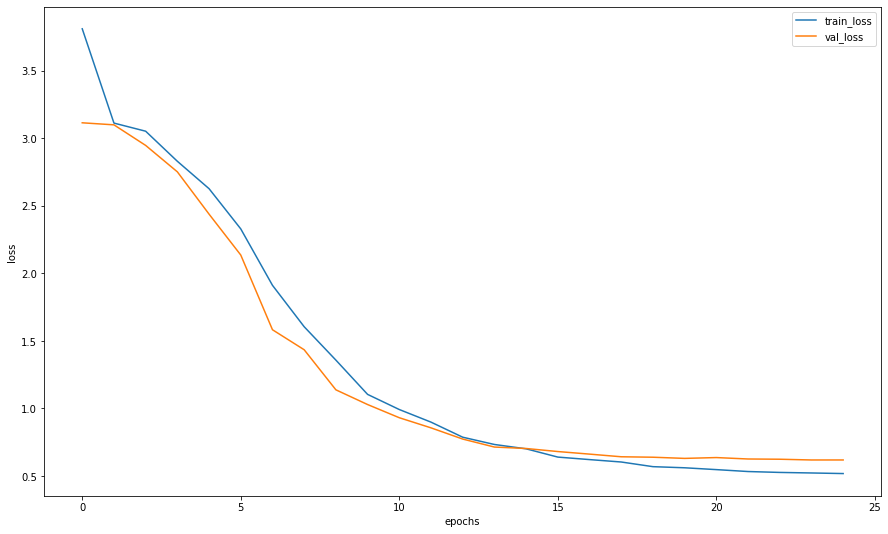

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

<a id='resnet_predict'></a>
## Предсказания

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Посмотрим на нашу метрику

In [40]:
f1_score(actual_labels, y_pred, average='micro')

0.7

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

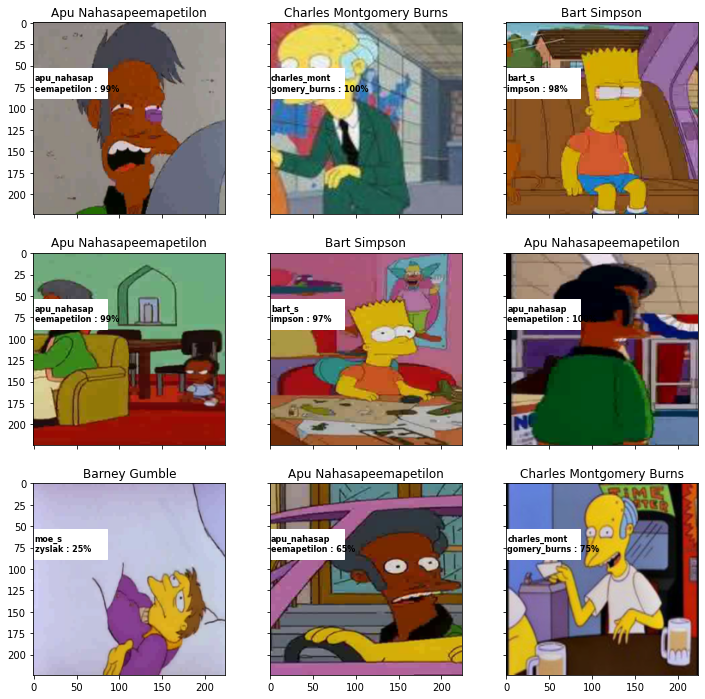

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(
        predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

<a id='resnet_sub'></a>
## Submit на Kaggle

In [42]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [43]:
! ls

__notebook_source__.ipynb  path_to\model_25epoch_weights.pth
label_encoder.pkl	   path_to\model_pre_weights.pth


In [44]:
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [45]:
mysubmit[f'Expected'] = preds
mysubmit.to_csv('resnet18_25epoch.csv', index=False)

---------------------
<a id='efficientnet'></a>
# EfficientNet B4

In [21]:
!pip install - -upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7cbaf6d9694731705764f385817c3b233e607cae931502c6492d4f282243e995
  Stored in directory: /root/.cache/pip/wheels/63/17/7e/07f1c55a623c96ba9b291c5d2e4901afffb953b032c2470ca6
Successfully built efficientnet-pytorch


In [22]:
import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [23]:
def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    # Загрузить EfficientNet предобученную на ImageNet
    model = EfficientNet.from_pretrained(model_name)

    # Изменить out_features последнего FC-слоя
    dim_feats = model._fc.in_features
    model.linear_last = nn.Linear(dim_feats, num_classes)

    return model


model_name = 'efficientnet-b4'
model = get_model(model_name, 42)
# model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [24]:
torch.cuda.empty_cache()

model = model.cuda()

<a id='effic_train'></a>
## Обучение

In [25]:
history = train(new_train_dataset, val_dataset,
                model=model, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.5873995668042434


epoch:   5%|▌         | 1/20 [06:06<1:56:07, 366.73s/it]


Epoch 001 train_loss: 0.5874     val_loss 0.2317 train_acc 0.8735 val_acc 0.9438
loss 0.30658755194945414


epoch:  10%|█         | 2/20 [11:41<1:47:10, 357.27s/it]


Epoch 002 train_loss: 0.3066     val_loss 0.3013 train_acc 0.9218 val_acc 0.9243
loss 0.1618918032120308


epoch:  15%|█▌        | 3/20 [17:16<1:39:19, 350.53s/it]


Epoch 003 train_loss: 0.1619     val_loss 0.2381 train_acc 0.9595 val_acc 0.9440
loss 0.06254465185139112


epoch:  20%|██        | 4/20 [22:52<1:32:17, 346.12s/it]


Epoch 004 train_loss: 0.0625     val_loss 0.1057 train_acc 0.9837 val_acc 0.9752
loss 0.03958464750323317


epoch:  25%|██▌       | 5/20 [28:26<1:25:39, 342.61s/it]


Epoch 005 train_loss: 0.0396     val_loss 0.1034 train_acc 0.9899 val_acc 0.9778
loss 0.04122653166068115


epoch:  30%|███       | 6/20 [34:00<1:19:18, 339.91s/it]


Epoch 006 train_loss: 0.0412     val_loss 0.1325 train_acc 0.9887 val_acc 0.9710
loss 0.01983596217969846


epoch:  35%|███▌      | 7/20 [39:36<1:13:22, 338.64s/it]


Epoch 007 train_loss: 0.0198     val_loss 0.0816 train_acc 0.9947 val_acc 0.9832
loss 0.012904660023982053


epoch:  40%|████      | 8/20 [45:11<1:07:30, 337.57s/it]


Epoch 008 train_loss: 0.0129     val_loss 0.1083 train_acc 0.9964 val_acc 0.9775
loss 0.010411607659520407


epoch:  45%|████▌     | 9/20 [50:46<1:01:43, 336.70s/it]


Epoch 009 train_loss: 0.0104     val_loss 0.1045 train_acc 0.9969 val_acc 0.9811
loss 0.0061577876305260355


epoch:  50%|█████     | 10/20 [56:23<56:08, 336.81s/it] 


Epoch 010 train_loss: 0.0062     val_loss 0.0903 train_acc 0.9980 val_acc 0.9840
loss 0.0033417844647977463


epoch:  55%|█████▌    | 11/20 [1:01:57<50:25, 336.12s/it]


Epoch 011 train_loss: 0.0033     val_loss 0.1004 train_acc 0.9990 val_acc 0.9840
loss 0.002889642305949761


epoch:  60%|██████    | 12/20 [1:07:33<44:47, 335.98s/it]


Epoch 012 train_loss: 0.0029     val_loss 0.0960 train_acc 0.9993 val_acc 0.9853
loss 0.003037549744064513


epoch:  65%|██████▌   | 13/20 [1:13:10<39:14, 336.36s/it]


Epoch 013 train_loss: 0.0030     val_loss 0.0916 train_acc 0.9989 val_acc 0.9851
loss 0.0008863946853202786


epoch:  70%|███████   | 14/20 [1:18:46<33:36, 336.15s/it]


Epoch 014 train_loss: 0.0009     val_loss 0.0958 train_acc 0.9997 val_acc 0.9855
loss 0.001806393021442851


epoch:  75%|███████▌  | 15/20 [1:24:20<27:57, 335.54s/it]


Epoch 015 train_loss: 0.0018     val_loss 0.1047 train_acc 0.9995 val_acc 0.9841
loss 0.0010289525621516517


epoch:  80%|████████  | 16/20 [1:29:56<22:23, 335.77s/it]


Epoch 016 train_loss: 0.0010     val_loss 0.1014 train_acc 0.9996 val_acc 0.9859
loss 0.0007325693765091647


epoch:  85%|████████▌ | 17/20 [1:35:33<16:48, 336.21s/it]


Epoch 017 train_loss: 0.0007     val_loss 0.1026 train_acc 0.9999 val_acc 0.9843
loss 0.0006412779343288097


epoch:  90%|█████████ | 18/20 [1:41:08<11:11, 335.89s/it]


Epoch 018 train_loss: 0.0006     val_loss 0.1052 train_acc 0.9998 val_acc 0.9853
loss 0.0006115053254339272


epoch:  95%|█████████▌| 19/20 [1:46:44<05:35, 335.90s/it]


Epoch 019 train_loss: 0.0006     val_loss 0.1033 train_acc 0.9999 val_acc 0.9849
loss 0.000462358115149326


epoch: 100%|██████████| 20/20 [1:52:20<00:00, 337.03s/it]


Epoch 020 train_loss: 0.0005     val_loss 0.1031 train_acc 0.9999 val_acc 0.9847


In [26]:
# сохранить веса нашей нейросети model
model_Effic_weights = copy.deepcopy(model.state_dict())
torch.save(model_Effic_weights, "path_to\\model_effic_weights.pth")

In [27]:
# загружаем сохраненное состояние весов нейросети
# model.load_state_dict(torch.load("path_to\\model_effic_weights.pth"))

Построим кривые обучения

In [28]:
loss, acc, val_loss, val_acc = zip(*history)

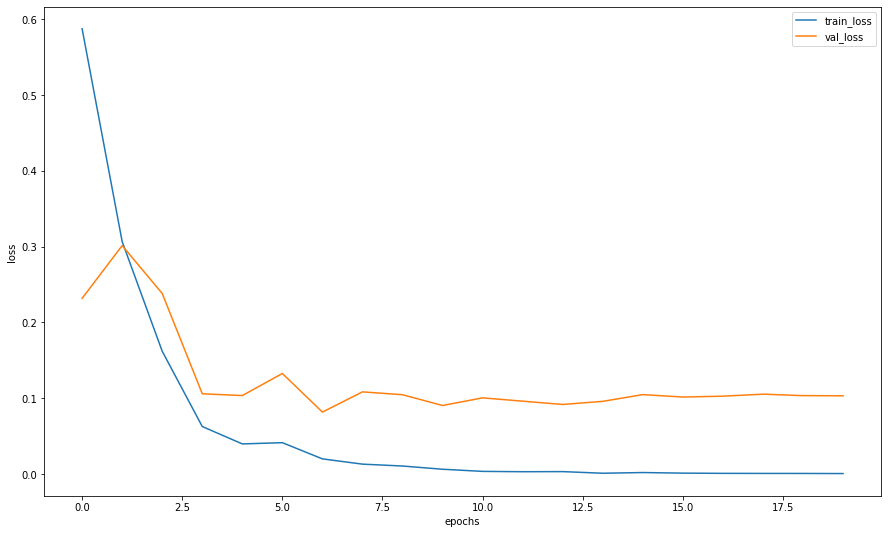

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Видно, что для `EfficientNet B4` можно было брать меньшее количество эпох. Например, около 10

<a id='effic_predict'></a>
## Предсказания

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую необходимо оптимизировать в конкурсе --- `f1-score`. Вычислим целевую метрику на валидационной выборке.

In [35]:
f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем визуализацию, чтобы посмотреть, насколько сеть уверена в своих ответах

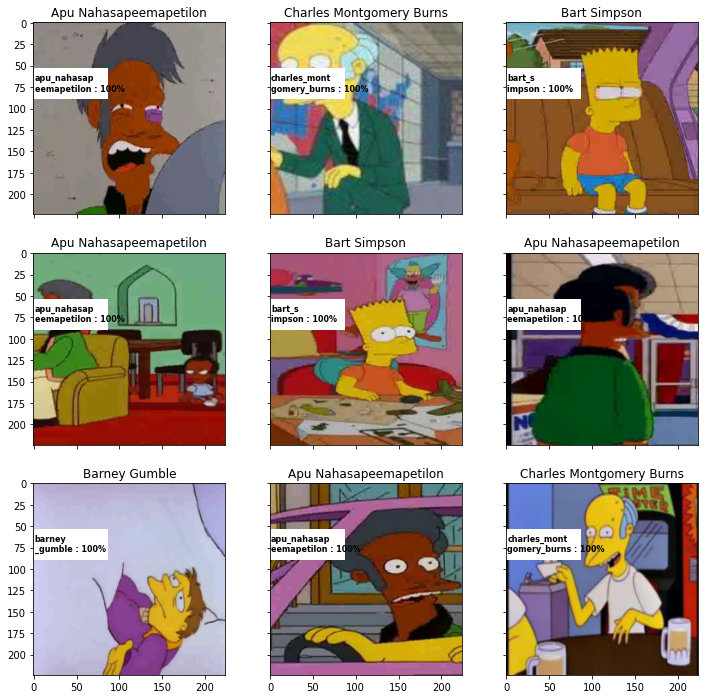

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(),
           title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(
        predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='black', fontweight='bold')

Видим, что сеть уверена в этих предсказаниях на 100%.

<a id='effic_sub'></a>
## Submit на Kaggle

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [38]:
! ls

__notebook_source__.ipynb  label_encoder.pkl  path_to\model_effic_weights.pth


In [39]:
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [40]:
mysubmit[f'Expected'] = preds
mysubmit.to_csv('effic6_20epoch.csv', index=False)

<a id='conclusion'></a>
# Заключение

При обучении `ResNet 18` на 30 эпохах Public Score на Kaggl'e оказался порядка 0.94048. При использовании `EfficientNet B4` было получено значение Public Score 0.99362. Таким образом, использование сети с архитектурой `EfficientNet` при прочих равных может быть более подходящей для задач компьютерного зрения, чем `ResNet`.